**I. Merging all dF**

In [1]:
import pandas as pd
import numpy as np
from contextlib import contextmanager
import gc
import time


@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [
        col for col in df.columns if df[col].dtype == 'object'
    ]
    df = pd.get_dummies(df,
                        columns=categorical_columns,
                        dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows=None, nan_as_category=False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows=num_rows)
    test_df = pd.read_csv('application_test.csv', nrows=num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    print(df['CODE_GENDER'][0])
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    print(df['CODE_GENDER'][0])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df


# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows=None, nan_as_category=True):
    bureau = pd.read_csv('bureau.csv', nrows=num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows=num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index(
        [e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({
        **num_aggregations,
        **cat_aggregations
    })
    bureau_agg.columns = pd.Index([
        'BURO_' + e[0] + "_" + e[1].upper()
        for e in bureau_agg.columns.tolist()
    ])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index([
        'ACTIVE_' + e[0] + "_" + e[1].upper()
        for e in active_agg.columns.tolist()
    ])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index([
        'CLOSED_' + e[0] + "_" + e[1].upper()
        for e in closed_agg.columns.tolist()
    ])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg


# Preprocess previous_applications.csv
def previous_applications(num_rows=None, nan_as_category=True):
    prev = pd.read_csv('previous_application.csv', nrows=num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({
        **num_aggregations,
        **cat_aggregations
    })
    prev_agg.columns = pd.Index([
        'PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()
    ])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index([
        'APPROVED_' + e[0] + "_" + e[1].upper()
        for e in approved_agg.columns.tolist()
    ])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index([
        'REFUSED_' + e[0] + "_" + e[1].upper()
        for e in refused_agg.columns.tolist()
    ])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows=None, nan_as_category=True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(
        ['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg


# Preprocess installments_payments.csv
def installments_payments(num_rows=None, nan_as_category=True):
    ins = pd.read_csv('installments_payments.csv', nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index([
        'INSTAL_' + e[0] + "_" + e[1].upper()
        for e in ins_agg.columns.tolist()
    ])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg


# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows=None, nan_as_category=True):
    cc = pd.read_csv('credit_card_balance.csv', nrows=num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(
        ['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [ ]:
# Let the process do its job and then collect the merged dF
num_rows = None
df = application_train_test(num_rows)

with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()
with timer("Save df"):
    df.to_csv('merged_df.csv.gz', compression='gzip', index=False)

**II. Load dF**

*II.1 Charging dataset* 

In [ ]:
import pandas as pd
import gc
import re

# Pandas option to display dF efficiently
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 200)

df = pd.read_csv('merged_df.csv.gz', compression='gzip')

# Collect features
feats = [
    f for f in df.columns if f not in
    ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']
]

# Create dF with all features without TARGET
train_df = df[df['TARGET'].notnull()][feats]
train_df = train_df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

# Create dF TARGET
train_target = df[df['TARGET'].notnull()]['TARGET']

# Create dF test for submission to Kaggle Leaderboard
test_df = df[df['TARGET'].isnull()][feats]
test_df = test_df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

del df
gc.collect()

*II.2 Exploring dataset* 

In [ ]:
print(('Trainset shape {} Testset shape {} Target shape {}').format(
    train_df.shape, test_df.shape, train_target.shape))

In [ ]:
display(train_df.head())

In [ ]:
train_target.value_counts()
# It returns us an imbalanced problem

In [ ]:
print('Positive / Negative ratio: ', 24825 / 282682)

In [ ]:
import numpy as np

var = pd.concat([train_df, train_target], axis=1)
tar0 = np.mean(var['AMT_CREDIT'][var['TARGET'] == 0] * 1 / 100)
tar1 = np.mean(var['AMT_CREDIT'][var['TARGET'] == 1] * 1 / 100)

print('Estimation of loan interest at 1% of the credit by clients target')
print('Negative clients: ', np.round(tar0))
print('Positive clients: ', np.round(tar1))

In [ ]:
# Function to calculate missing values by column
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [ ]:
# Missing values statistics
missing_values = missing_values_table(train_df)
display(missing_values)

**III. A few feature engineering**

In [ ]:
# All the process below are storing a dF of correlation between features
# Correlation dF are processing with [simple features, log, square root, squared and cubic function]

corr_matrix = pd.concat([train_df, train_target], axis=1).corr()

corr_matrix_log = pd.concat([train_df.add(1).apply(np.log), train_target],
                            axis=1).corr()

corr_matrix_sqrt = pd.concat(
    [train_df.add(1).apply(np.abs).apply(np.sqrt), train_target],
    axis=1).corr()

corr_matrix_sq = pd.concat([train_df.apply(lambda x: x**2), train_target],
                           axis=1).corr()

corr_matrix_cub = pd.concat([train_df.apply(lambda x: x**3), train_target],
                            axis=1).corr()


In [ ]:
# Concatenate the correlations values to the TARGET
corr = pd.concat([
    corr_matrix['TARGET'], corr_matrix_log['TARGET'],
    corr_matrix_sqrt['TARGET'], corr_matrix_sq['TARGET'],
    corr_matrix_cub['TARGET']
],
    names=['simple ft', 'log', 'sqrt', 'squared', 'cubic'],
    axis=1)

# Export the results in a csv
corr.to_csv('corr_matrix.csv')

In [ ]:
# Use the results to analyse best correlation values
corr = pd.read_csv('corr_matrix.csv')
corr.columns = ['name', 'simple ft', 'log', 'sqrt', 'squared', 'cubic']
corr.drop(index=795, inplace=True)

# Drop features **2 and **3 because no results were probants
corr.drop(columns=['squared', 'cubic'], inplace=True)

In [ ]:
# Display the best correlation and inversed correlation values
# Only the log and square root give useful results
display(corr.sort_values(by='log', ascending=False).head(10))
print('Best log correlated features')

display(corr.sort_values(by='sqrt', ascending=False).head(10))
print('Best sqrt correlated features')

display(corr.sort_values(by='log').head(10))
print('Best log inverse correlated features')

display(corr.sort_values(by='sqrt').head(10))
print('Best sqrt inverse correlated features')

In [ ]:
import numpy as np

# Results shows us some features that can be pass to log
features_to_log = [
    'EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1',
    'CC_CNT_DRAWINGS_CURRENT_VAR', 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
    'CC_CNT_DRAWINGS_CURRENT_MEAN'
]

# Apply the transformation
train_df.loc[:, features_to_log] = train_df.loc[:,
                                                features_to_log].add(1).apply(
                                                    np.log)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

var = pd.concat([train_df, train_target], axis=1)
plt.figure(figsize=(10, 12))

# iterate through the sources
for i, source in enumerate(features_to_log):
    # create a new subplot for each source
    plt.subplot(3, 2, i + 1)
    # plot repaid loans
    sns.kdeplot(var.loc[var['TARGET'] == 0, source], label='target=0')
    # plot loans that were not repaid
    sns.kdeplot(var.loc[var['TARGET'] == 1, source], label='target=1')

    # Label the plots
    plt.title('Distribution of %s' % source)
    plt.xlabel('%s' % source)
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout(h_pad=2.5)

**IV. Hyperopt bayesian optimization for hyperparameters**

*IV.1 Some functions to define custom metrics, model training and bayesian optimisation*

In [ ]:
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix, f1_score, roc_auc_score
from hyperopt import STATUS_OK
import shap


def calculate_cost(train_target, pred_array):
    """Custom metrics given to model.fit"""
    cost = list()
    precision, recall, thresholds = precision_recall_curve(
        train_target, pred_array)
    fscore = (2 * precision * recall) / (precision + recall)
    
    for t in np.linspace(np.min(thresholds), np.max(thresholds), 50):
        pred_array_rounded = np.where(pred_array > t, 1., 0.)
        tn, fp, fn, tp = confusion_matrix(
            train_target, pred_array_rounded).ravel()
        cost.append(fp * 0.1 + fn)        

    #ix = np.argmax(fscore)
    ix = np.argmin(cost)
    
    return 'Cost', cost[ix], False


def bayesian_optimizer(space_params):
    """Function to optimize hyperparameter of the LightGBM Classifier with a Bayesian approach.
    In output we collect some metrics as F1score, precision, recall and confusion_matrix"""

    # Declare variables to store essential outputs of the function
    pred_array = np.zeros(train_df.shape[0])
    shap_values_zero = np.zeros((train_df.shape[0], train_df.shape[1]))
    shap_values_one = np.zeros((train_df.shape[0], train_df.shape[1]))
    metrics_results = dict()

    # Go into the for loop and cross validation in 5 folds
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    for i, (train_idx,
            test_idx) in enumerate(skf.split(train_df, train_target)):
        X_train, y_train = train_df.iloc[train_idx], train_target.iloc[
            train_idx]
        X_test, y_test = train_df.iloc[test_idx], train_target.iloc[test_idx]

        # Instanciate the LightGBM Classifier
        model = LGBMClassifier(**space_params)
        # And fit with training datas
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_train, y_train), (X_test, y_test)],
                  eval_metric=calculate_cost,
                  verbose=100,
                  early_stopping_rounds=20)

        # Record the shap values to plot some graphs later
        explainer = shap.TreeExplainer(model)
        shap_values_zero[test_idx], shap_values_one[
            test_idx] = explainer.shap_values(X_test)

        # Record the predictions done with testing datas
        pred_array[test_idx] = model.predict_proba(
            X_test, num_iteration=int(model.best_iteration_))[:, 1]

    # Record all the metrics in the metrics_result dictionnary
    metrics_results['pred_array'] = pred_array


    # Record other important value to plot shap

    metrics_results['shap_values'] = shap_values_zero, shap_values_one
    metrics_results['shap_expect_values'] = explainer.expected_value

    print('******************************************************************')
    print('Model trained and predictions done')
    print('******************************************************************')

    
    del model, X_test, y_test, X_train, y_train
    gc.collect()

    return metrics_results


def function_to_optimize_cost(space_params):
    cost = list()
    
    metrics = bayesian_optimizer(space_params)
    pred_array = metrics['pred_array']
    #auc = roc_auc_score(train_target, pred_array)
    fscore = (2 * precision * recall) / (precision + recall)

    precision, recall, thresholds = precision_recall_curve(
        train_target, pred_array)
    

    # locate the index of the largest f score
    #ix = np.argmax(fscore)

    for t in np.linspace(np.min(thresholds), np.max(thresholds), 10):
        pred_array_rounded = np.where(pred_array > t, 1., 0.)
        tn, fp, fn, tp = confusion_matrix(
            train_target, pred_array_rounded).ravel()
        cost.append(fp * 0.1 + fn)
        
    ix = np.argmin(cost)

    return {'loss': cost[ix], 'status': STATUS_OK}

*IV.2 Run the bayesian optimisation*

In [ ]:
from hyperopt import Trials, hp, tpe, fmin, space_eval, STATUS_OK
from hyperopt.pyll import scope
import warnings

warnings.filterwarnings("ignore")

space_params = {
    # 'is_unbalance': hp.choice('is_unbalance', [True, False]),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0.01, 1.),
    'n_estimators':
    hp.choice('n_estimators', np.arange(100, 1500, 1000)),  # go for int values
    'learning_rate':
    hp.uniform('learning_rate', 0.0001, 0.2),
    'num_leaves':
    hp.choice('num_leaves', np.arange(30, 150, 1)),
    'colsample_bytree':
    hp.uniform('colsample_bytree', 0.01, 0.9),
    'subsample':
    hp.uniform('subsample', 0.01, 0.9),
    'max_depth':
    hp.choice('max_depth', range(4, 10, 1)),  # go for int values
    'reg_alpha':
    hp.uniform('reg_alpha', 0., 0.4),
    'reg_lambda':
    hp.uniform('reg_lambda', 0., 0.4),
    'min_split_gain':
    hp.uniform('min_split_gain', 0.01, 0.1),
    'min_child_weight':
    hp.uniform('min_child_weight', 10, 70)
}

trials = Trials()

best_params_auc = fmin(fn=function_to_optimize_cost,
                   space=space_params,
                   algo=tpe.suggest,
                   max_evals=20,
                   trials=trials,
                   verbose=50)

print('******************************************************************')
print('Best parameters AUC with bayesian optimization are :', '\n')
print(best_params_auc)
print('******************************************************************')

In [ ]:
trials = Trials()

best_params_fscore = fmin(fn=function_to_optimize_cost,
                   space=space_params,
                   algo=tpe.suggest,
                   max_evals=20,
                   trials=trials,
                   verbose=50)

print('******************************************************************')
print('Best parameters F-Score with bayesian optimization are :', '\n')
print(best_params_fscore)
print('******************************************************************')

In [ ]:
trials = Trials()

best_params_cost = fmin(fn=function_to_optimize_cost,
                   space=space_params,
                   algo=tpe.suggest,
                   max_evals=20,
                   trials=trials,
                   verbose=10)

print('******************************************************************')
print('Best parameters with bayesian optimization are :', '\n')
print(best_params_cost)
print('******************************************************************')

In [ ]:
best_params_auc = dict()
best_params_fscore = dict()
best_params_cost = dict()

for i, j in pd.read_csv('best_params_auc.csv').values:
    best_params_auc[i] = j
    
for i, j in pd.read_csv('best_params_fscore.csv').values:
    best_params_fscore[i] = j
    
for i, j in pd.read_csv('best_params_cost.csv').values:
    best_params_cost[i] = j
    
best_params_auc['first_metric_only'] = True
best_params_fscore['first_metric_only'] = True
best_params_cost['first_metric_only'] = True

best_params_auc['n_estimators'] = int(best_params_auc['n_estimators'])
best_params_auc['max_depth'] = int(best_params_auc['max_depth'])
best_params_auc['num_leaves'] = int(best_params_auc['num_leaves'])

best_params_fscore['n_estimators'] = int(best_params_fscore['n_estimators'])
best_params_fscore['max_depth'] = int(best_params_fscore['max_depth'])
best_params_fscore['num_leaves'] = int(best_params_fscore['num_leaves'])

best_params_cost['n_estimators'] = int(best_params_cost['n_estimators'])
best_params_cost['max_depth'] = int(best_params_cost['max_depth'])
best_params_cost['num_leaves'] = int(best_params_cost['num_leaves'])

**V. Initiate the model and plot some graphs about performance**

*V.1 AUC as metric to train the model*

In [ ]:
metrics_auc = bayesian_optimizer(best_params_auc)

In [59]:
pred_array = metrics_auc['pred_array']

precision, recall, thresholds = precision_recall_curve(
        train_target, pred_array)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)

print('AUC ROC score: ', roc_auc_score(train_target, pred_array))
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

AUC ROC score:  0.7863678473007646
Best Threshold=0.169451, F-Score=0.337


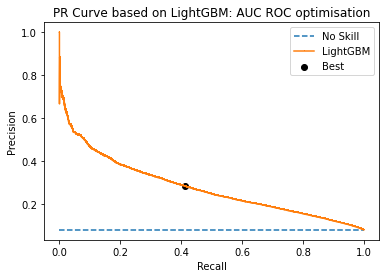

In [60]:
# plot the PR curve for the model
no_skill = len(train_target[train_target == 1]) / len(train_target)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker=',', label='LightGBM')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.title('PR Curve based on LightGBM: AUC ROC optimisation')
# show the plot
plt.show()

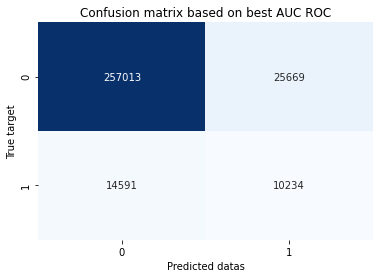

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Round the predicted results
pred_array_rounded = np.where(pred_array > thresholds[ix], 1., 0.)

cm = confusion_matrix(train_target, pred_array_rounded)
sns.heatmap(cm, annot=True, fmt='', cmap='Blues', cbar=False)

plt.title('Confusion matrix based on best AUC ROC')
plt.xlabel('Predicted datas')
plt.ylabel('True target')

plt.show()

*V.1 F-Score as metric to train the model*

In [ ]:
metrics_fscore = bayesian_optimizer(best_params_fscore)

In [47]:
pred_array = metrics_fscore['pred_array']


precision, recall, thresholds = precision_recall_curve(
        train_target, pred_array)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print('AUC ROC score: ', roc_auc_score(train_target, pred_array))
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

AUC ROC score:  0.7738057961613879
Best Threshold=0.154461, F-Score=0.323


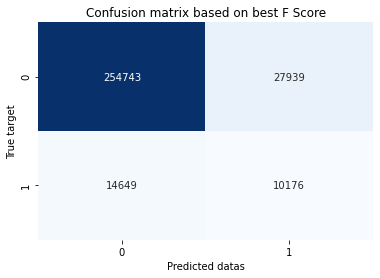

In [48]:
# Round the predicted results
pred_array_rounded = np.where(pred_array > thresholds[ix], 1., 0.)

cm = confusion_matrix(train_target, pred_array_rounded)
sns.heatmap(cm, annot=True, fmt='', cmap='Blues', cbar=False)

plt.title('Confusion matrix based on best F Score')
plt.xlabel('Predicted datas')
plt.ylabel('True target')

plt.show()

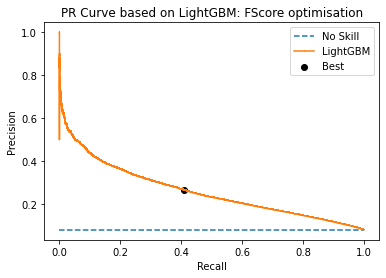

In [49]:
# plot the PR curve for the model
no_skill = len(train_target[train_target == 1]) / len(train_target)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker=',', label='LightGBM')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.title('PR Curve based on LightGBM: FScore optimisation')
# show the plot
plt.show()

**VI. Make the model more robust and then show the shap summary plot**

In [ ]:
import dill as pickle


pred_array = np.zeros((train_df.shape[0], train_df.shape[1]))
shap_values_zero = np.zeros((train_df.shape[0], train_df.shape[1]))
shap_values_one = np.zeros((train_df.shape[0], train_df.shape[1]))
metrics_results = dict()

# Instanciate the LightGBM Classifier
model = LGBMClassifier(**best_params_cost)
# And fit with training datas
model.fit(train_df,
          train_target,
          eval_set=[(train_df, train_target)],
          eval_metric=calculate_cost,
          verbose=10,
          early_stopping_rounds=20)

# Record model as pickle
light_gbm = 'model.pk'

with open('/Users/DrDjekyl/DataScience_OpenClassRooms/P7/repo_git/'+light_gbm,'wb') as f:
     pickle.dump(model, f)

In [83]:
# Record the shap values to plot some graphs later
explainer = shap.TreeExplainer(model)
shap_values_zero, shap_values_one = explainer.shap_values(train_df)

# Record the predictions done with testing datas
pred_array = model.predict_proba(
    train_df, num_iteration=int(model.best_iteration_))[:, 1]

# Record all the metrics in the metrics_result dictionnary
metrics_results['pred_array'] = pred_array

# Record other important value to plot shap
metrics_results['shap_values'] = shap_values_zero, shap_values_one
metrics_results['shap_expect_values'] = explainer.expected_value

print('******************************************************************')
print('Model trained and predictions done')
print('******************************************************************')

******************************************************************
Model trained and predictions done
******************************************************************


In [86]:
precision, recall, thresholds = precision_recall_curve(
        train_target, pred_array)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print('AUC ROC score: ', roc_auc_score(train_target, pred_array))
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

AUC ROC score:  0.8679180657510506
Best Threshold=0.184335, F-Score=0.463


In [92]:
cost = list()

for t in np.linspace(0.01, 0.2, 50):
    pred_array_rounded = np.where(pred_array > t, 1., 0.)
    tn, fp, fn, tp = confusion_matrix(
        train_target, pred_array_rounded).ravel()
    cost.append(fp * 0.1 + fn)        

ix = np.argmin(cost)
print('Best Threshold=%f, Cost=%.3f' % (thresholds[ix], cost[ix]))

Best Threshold=0.004981, Cost=11388.200


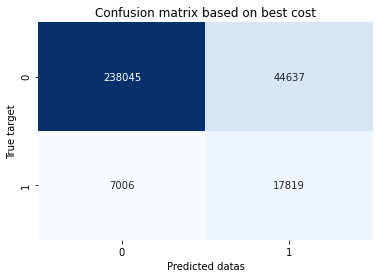

In [103]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


# Round the predicted results
pred_array_rounded = np.where(pred_array > 0.1, 1., 0.)

cm = confusion_matrix(train_target, pred_array_rounded)
sns.heatmap(cm, annot=True, fmt='', cmap='Blues', cbar=False)

plt.title('Confusion matrix based on best cost')
plt.xlabel('Predicted datas')
plt.ylabel('True target')

plt.show()

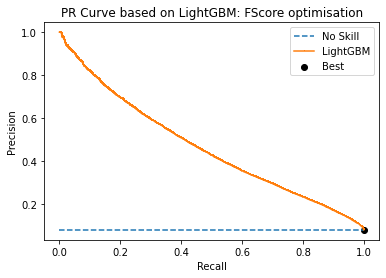

In [94]:
# plot the PR curve for the model
no_skill = len(train_target[train_target == 1]) / len(train_target)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker=',', label='LightGBM')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.title('PR Curve based on LightGBM: FScore optimisation')
# show the plot
plt.show()

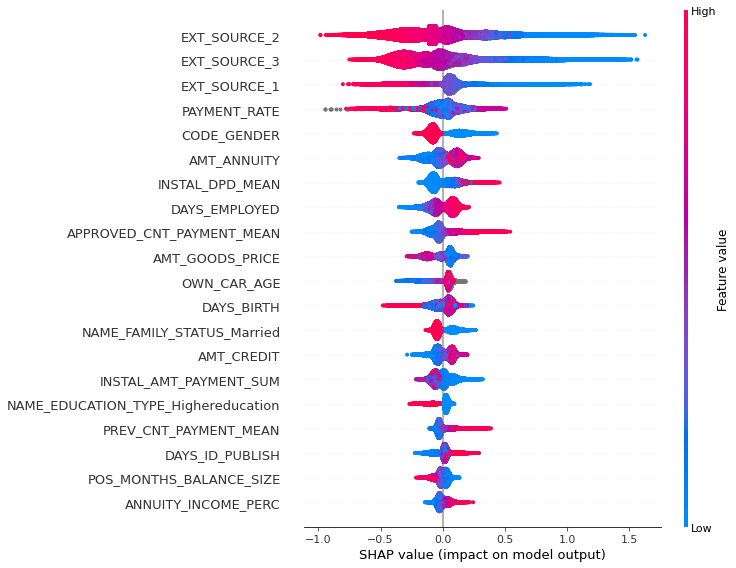

In [96]:
shap.summary_plot(metrics_results['shap_values'][1], train_df)

In [ ]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
plot = shap.plots.force(metrics_results['shap_expect_values'][1],
                 metrics_results['shap_values'][1][0], feature_names=train_df.columns)